Found 15 model prediction files to visualize


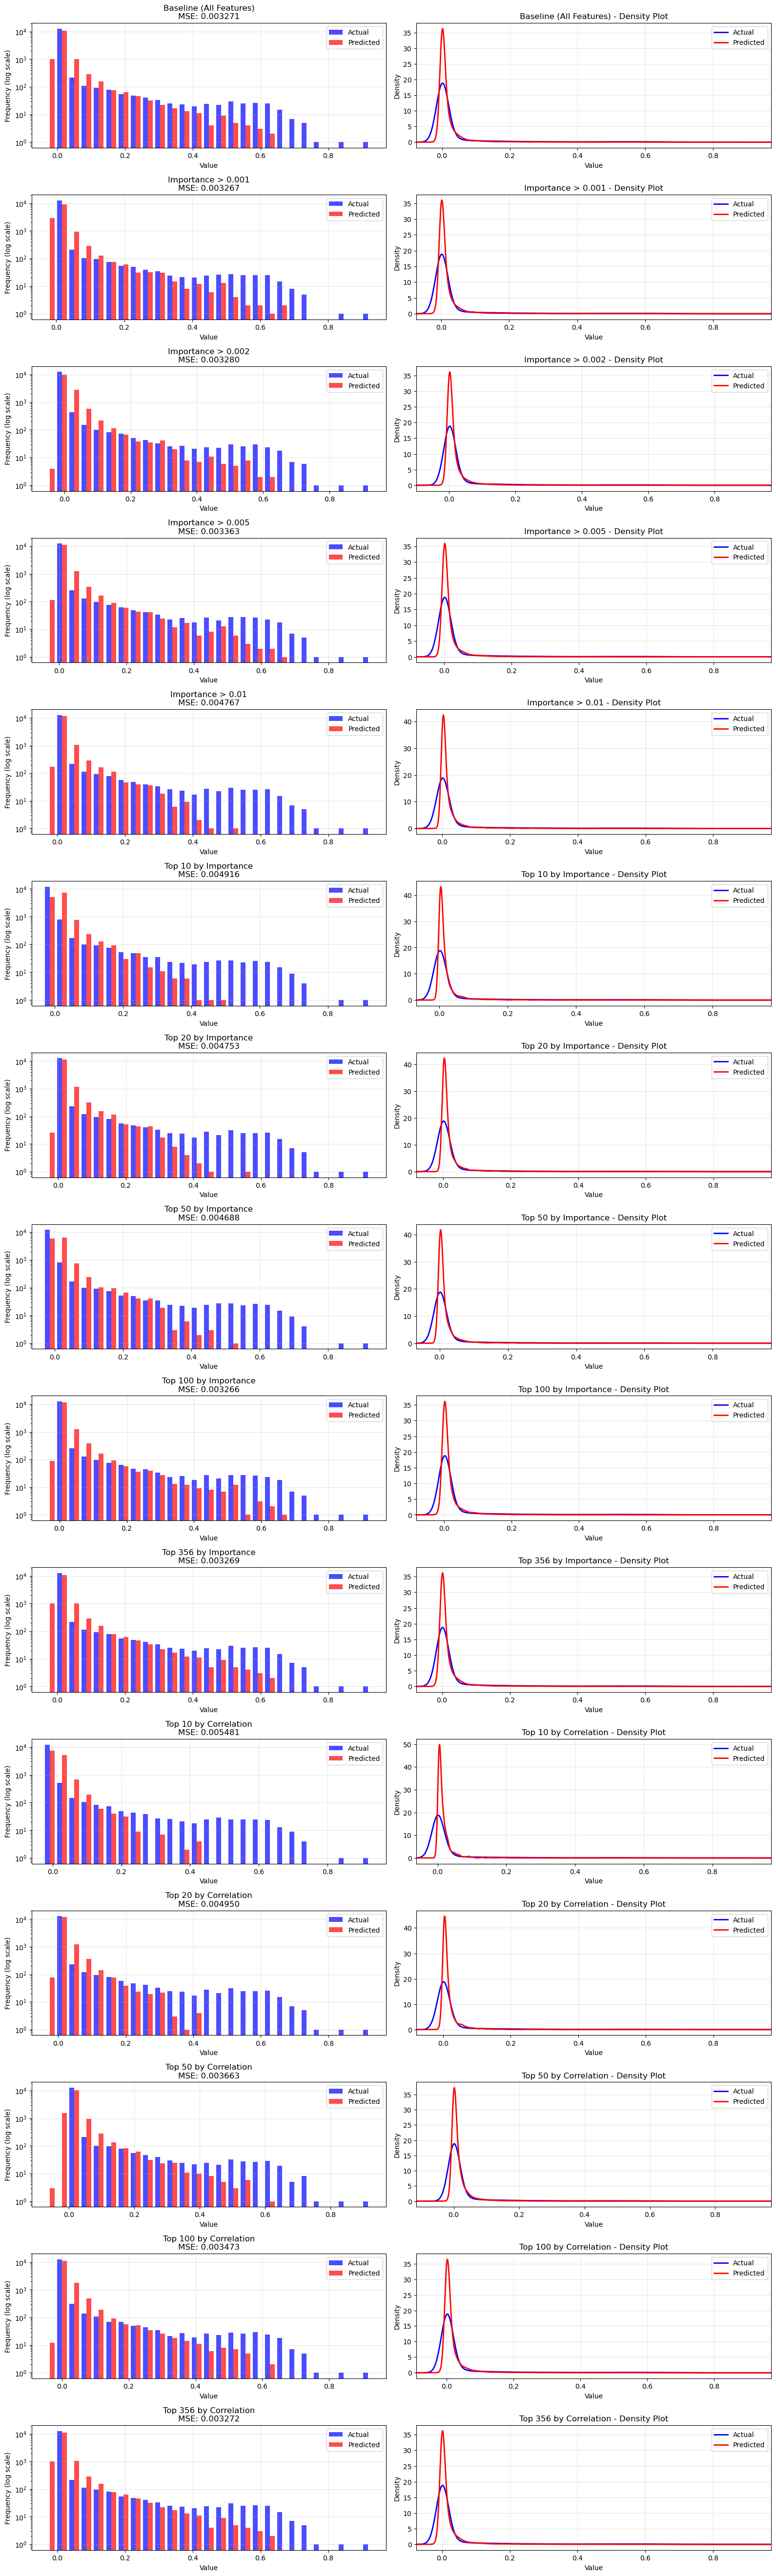

In [5]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import re

# Find all CSV files in the model_predictions directory
csv_files = glob.glob('model_predictions/*.csv')
print(f"Found {len(csv_files)} model prediction files to visualize")

# Determine grid size (rows and columns)
n_models = len(csv_files)
n_cols = min(2, n_models)  # Fixed 2 columns
n_rows = (n_models + n_cols - 1) // n_cols

# Create figure with tight layout
plt.figure(figsize=(16, 7 * n_rows))  # Adjusted for 2 columns and dual plots

# Function to extract model name from filename for sorting
def get_model_name(file_path):
    base_name = os.path.basename(file_path).replace('.csv', '')
    
    # Extract numeric value for sorting
    if 'threshold' in base_name:
        match = re.search(r'threshold_(\d+\.\d+)', base_name)
        if match:
            return (1, float(match.group(1)))
    elif 'top_k' in base_name:
        match = re.search(r'top_k_(\d+)', base_name)
        if match:
            return (2, int(match.group(1)))
    elif 'correlation_top' in base_name:
        match = re.search(r'correlation_top_(\d+)', base_name)
        if match:
            return (3, int(match.group(1)))
    elif 'baseline' in base_name:
        return (0, 0)
    
    return (4, base_name)  # For any other case

# Sort files in a logical order
csv_files.sort(key=get_model_name)

# Create subplots
for i, csv_file in enumerate(csv_files):
    # Create a subplot with 2 rows for each model
    plt.subplot(n_rows * 2, n_cols, i * 2 + 1)
    
    # Read the CSV file
    try:
        df = pd.read_csv(csv_file)
        
        # Check if the required columns are present
        if 'actual' not in df.columns or 'predicted' not in df.columns:
            print(f"Error: Required columns not found in {csv_file}")
            continue
        
        # Get pretty model name
        model_name = os.path.basename(csv_file).replace('.csv', '')
        
        # Format model name for display
        if model_name == 'baseline':
            display_name = "Baseline (All Features)"
        elif 'importance_threshold' in model_name:
            threshold = model_name.split('_')[-1]
            display_name = f"Importance > {threshold}"
        elif 'top_k' in model_name:
            k = model_name.split('_')[-1]
            display_name = f"Top {k} by Importance"
        elif 'correlation_top' in model_name:
            k = model_name.split('_')[-1]
            display_name = f"Top {k} by Correlation"
        else:
            display_name = model_name
        
        # Calculate metrics
        mse = np.mean((df['actual'] - df['predicted']) ** 2)
        
        # Create common bins for both plots
        bin_range = (
            min(df['actual'].min(), df['predicted'].min()) - 0.05,
            max(df['actual'].max(), df['predicted'].max()) + 0.05
        )
        bins = np.linspace(bin_range[0], bin_range[1], 30)
        
        # Plot 1: Side-by-side bars for better comparison
        plt.hist([df['actual'], df['predicted']], bins=bins, 
                 color=['blue', 'red'], alpha=0.7,
                 label=['Actual', 'Predicted'], histtype='bar')
        
        plt.title(f"{display_name}\nMSE: {mse:.6f}")
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend(loc='upper right')
        plt.grid(alpha=0.3)
        plt.xlim(bin_range)
        
        # Use log scale for y-axis if highly skewed
        if df['actual'].value_counts().max() > 5 * df['predicted'].value_counts().max():
            plt.yscale('log')
            plt.ylabel('Frequency (log scale)')
        
        # Add second plot (density plot) for the same data
        plt.subplot(n_rows * 2, n_cols, i * 2 + 2)
        
        # Create density plot using kernel density estimation
        from scipy.stats import gaussian_kde
        
        # Only include non-zero values for KDE estimation
        actual_kde = df['actual'][df['actual'] != 0]
        pred_kde = df['predicted'][df['predicted'] != 0]
        
        if len(actual_kde) > 1:  # Need at least 2 points for KDE
            x_grid = np.linspace(bin_range[0], bin_range[1], 1000)
            
            # Calculate densities
            try:
                actual_density = gaussian_kde(actual_kde)(x_grid)
                plt.plot(x_grid, actual_density, color='blue', lw=2, label='Actual')
            except:
                print(f"KDE failed for actual values in {csv_file}")
        
        if len(pred_kde) > 1:  # Need at least 2 points for KDE
            try:
                pred_density = gaussian_kde(pred_kde)(x_grid)
                plt.plot(x_grid, pred_density, color='red', lw=2, label='Predicted')
            except:
                print(f"KDE failed for predicted values in {csv_file}")
        
        plt.title(f"{display_name} - Density Plot")
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend(loc='upper right')
        plt.grid(alpha=0.3)
        plt.xlim(bin_range)
        
    except Exception as e:
        print(f"Error processing {csv_file}: {e}")

# Adjust layout to be tight
plt.tight_layout()

# Show the plot if running in interactive mode
plt.show()